# Loan Data from Prosper Exploration
## by Jeff Mitchell

## Preliminary Wrangling

This dataset contains information on nearly 114,000 loans from Prosper. The dataset contains a lot of features and will require some wrangling before I can start analysing it.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
loans = pd.read_csv('prosperLoanData.csv')

In [3]:
# high-level overview of data shape and composition
print(loans.shape)
print(loans.dtypes)

(113937, 81)
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration               float64


### What is the structure of your dataset?

There are 113,937 loans with 81 features for each loan. This is a lot of features and some are only relevant to certain periods of time (e.g. pre-2009, post-July 2009). These features include details such as Term, Loan status, Borrower rate, various scores and ratings, demographic features such as Occupation, Employment status, Home ownership, various credit scores and totals, income range and details specific to the loan.

Each loan can be identified by its unique LoanNumber. There are other unique columns such as ListingNumber, ListingKey etc., however, each of these can be related back to the LoanNumber.

### What is/are the main feature(s) of interest in your dataset?

I am most interested in finding out what features have the greatest impact on Loan Outcome Status, specifically on whether or not the loan is paid off.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Features of interest in investigating Loan Outcome Status include the reason for the loan (ListingCategory), their employment status (EmploymentStatus), their credit scores, their monthly income, the amount of the loan (LoanOriginalAmount) and level of monthly payments (MonthlyLoanPayment). Other features that may also be worth investigating include the number of delinquincies, their debt-to-income ratio (DebtToIncomeRatio) and their home ownership status. I expect that borrowers with higher debt-to-income ratios, lower monthly income and lower credit scores are less likely to complete their loan payments.

### Initial cleaning

A quick visual assessment of the raw the data file using Excel shows that the data requires some initial cleaning before I can start analysing it. This will involve dropping unnecessary columns, cleaning column types and creating new columns to help with the analysis.

The large number of columns in the data will make analysis difficult. I will start by reducing the dataframe to only the columns that are of interest to me for investigating the Loan Outcome Status. For example, LoanNumber can be used to identify individual loans. This removes the need to hold ListingNumber, ListingKey and LoanKey which are all associated with a unique LoanNumber.

In [4]:
# Reduce the number of columns to just those that may be of interest
columns = ['Term', 'LoanStatus', 'BorrowerAPR', 'ListingCategory (numeric)', 'EmploymentStatus', 'IsBorrowerHomeowner', 
           'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'TotalCreditLinespast7years', 'DelinquenciesLast7Years', 
           'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanNumber', 'LoanOriginalAmount', 'LoanOriginationQuarter',
           'MemberKey', 'MonthlyLoanPayment']
loans = loans[columns]

Some of the column headings are confusing or difficult to work with so I will rename them.

In [5]:
loans = loans.rename(columns={'ListingCategory (numeric)':'ListingCategory','IsBorrowerHomeowner':'HomeOwner',
                              'TotalCreditLinespast7years':'TotalCreditLines',
                              'DelinquenciesLast7Years':'TotalDelinquencies'})

I am interested in the effect of the features on Loan Outcome Status. Loans that have not yet reached an outcome need to be removed as I do not know what their final outcome will be (I cannot identify what effect their features have on Loan Outcome Status as their status is not yet known). First I will check the values in the LoanStatus column.

In [6]:
loans.LoanStatus.value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

For this analysis I am going to consider 'Chargedoff' and 'Defaulted' as loans that were not completed successfully. Loans that are 'Past Due...' I will consider current as they still have the potential to be completed. The loans to be removed are those listed as 'Current', 'Past Due...' and 'FinalPaymentInProgress'. 

In [7]:
# Remove loans that have not reached an outcome
loans = loans[loans['LoanStatus'].isin(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'])]
loans.LoanStatus.value_counts()

Completed     38074
Chargedoff    11992
Defaulted      5018
Cancelled         5
Name: LoanStatus, dtype: int64

As I will be using LoanNumber to identify unique loans, I need to make sure there are no duplicated loan records.

In [8]:
dupes = loans[loans['LoanNumber'].duplicated() == True]
dupes

,Term,LoanStatus,BorrowerAPR,ListingCategory,EmploymentStatus,HomeOwner,CreditScoreRangeLower,CreditScoreRangeUpper,TotalCreditLines,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment
33959,60,Completed,0.28875,3,Employed,False,660.0,679.0,61.0,0.0,0.33,4506.666667,131358,5500,Q1 2014,85D535659273197054A0BB3,165.45
37956,36,Completed,0.22875,1,Employed,False,660.0,679.0,19.0,0.0,0.20,6083.333333,105288,20000,Q4 2013,8EC335867884136891E9E14,734.64
51079,36,Completed,0.23438,1,Employed,True,660.0,679.0,43.0,0.0,0.16,14583.333333,123094,5000,Q4 2013,9FA83698836314377793393,185.05
60004,36,Completed,0.13799,7,Employed,True,680.0,699.0,21.0,1.0,0.23,4250.000000,110303,2000,Q4 2013,4553358888719707373CD1C,65.47
61289,36,Completed,0.09000,1,Self-employed,True,800.0,819.0,17.0,0.0,NaN,7500.000000,107275,3500,Q4 2013,34193560492599576667729,109.13
68585,36,Completed,0.18633,1,Employed,False,700.0,719.0,40.0,0.0,0.34,7500.000000,121979,15000,Q4 2013,27FA3533700778342A3BB33,519.98
70435,60,Completed,0.19988,1,Employed,True,720.0,739.0,26.0,0.0,0.26,4125.000000,119188,15000,Q4 2013,4FC835464074587007C7ABC,377.64
96475,60,Completed,0.22601,1,Employed,False,680.0,699.0,20.0,0.0,0.23,4125.000000,101908,15000,Q3 2013,7EF83383685864632D111F0,398.66
97137,36,Completed,0.32446,1,Employed,False,660.0,679.0,30.0,13.0,0.17,5833.333333,121751,4000,Q4 2013,4E9335537538907782E9392,166.54
97330,60,Completed,0.23318,1,Employed,True,680.0,699.0,26.0,0.0,0.32,4166.666667,118909,13000,Q4 2013,117636957815160767DC8DC,350.60


There are 13 duplicated records in the data based on LoanNumber. A visual check of these in the raw data showed that the only difference between the duplicates was the ProsperScore, which is not being used in this analysis. For this reason I can drop the duplicate rows, keeping only the first row (the default behaviour).

In [9]:
# Drop rows duplicated on LoanNumber
loans.drop_duplicates('LoanNumber', inplace=True)

I am interested in knowing the outcome of the loan - whether it was successfully paid off or not. This will be easiest by creating a new column that records the final status of the loan - LoanCompleted - which holds a string, either 'Completed' (paid off) or 'Not completed' (not paid off). This will be set to be a category type.

In [10]:
# Function to return loan completion status
def getLoanCompleted(loan_status):
    """Return 'Completed' if loan completed, 'Not completed' otherwise."""
    if loan_status.strip() == 'Completed':
        return 'Completed'
    else:
        return 'Not completed'
    
# Create column to hold status of loan outcome
loans['LoanCompleted'] = loans['LoanStatus'].apply(getLoanCompleted)
loans['LoanCompleted'] = loans['LoanCompleted'].astype('category')

# Drop LoanStatus column
loans.drop('LoanStatus', axis=1, inplace=True)

In [11]:
# Examine remaining columns
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55076 entries, 0 to 113935
Data columns (total 17 columns):
Term                      55076 non-null int64
BorrowerAPR               55051 non-null float64
ListingCategory           55076 non-null int64
EmploymentStatus          52821 non-null object
HomeOwner                 55076 non-null bool
CreditScoreRangeLower     54485 non-null float64
CreditScoreRangeUpper     54485 non-null float64
TotalCreditLines          54379 non-null float64
TotalDelinquencies        54086 non-null float64
DebtToIncomeRatio         50847 non-null float64
StatedMonthlyIncome       55076 non-null float64
LoanNumber                55076 non-null int64
LoanOriginalAmount        55076 non-null int64
LoanOriginationQuarter    55076 non-null object
MemberKey                 55076 non-null object
MonthlyLoanPayment        55076 non-null float64
LoanCompleted             55076 non-null category
dtypes: bool(1), category(1), float64(8), int64(4), object(3)
memory u

Several of the columns will need some cleaning before I can perform analysis on them. Firstly I will convert the LoanNumber to a string as I am using it as a reference only.

In [12]:
# Convert LoanNumber to a string as I will not perform calcluations on it
loans['LoanNumber'] = loans['LoanNumber'].astype('str')

The ListingCategory column currently only has ints. These will be much easier to analyse by converting them to a string that states what the int represents and then setting the column to category type.

In [13]:
# Convert the ListingCategory column to readable values
def convert_listing_category(cat):
    """Convert the listing category to a human-readable string."""
    categories = ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use',
                 'Auto', 'Other', 'Baby and Adoption', 'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans',
                 'Household Expenses', 'Large Purchases', 'Medical and Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation',
                 'Wedding']
    return categories[cat]

loans['ListingCategory'] = loans['ListingCategory'].apply(convert_listing_category)

# Convert ListingCategoy to categorical types
loans['ListingCategory'] = loans['ListingCategory'].astype('category')

There are null values in the EmploymentStatus column so I will take a closer look at the column.

In [14]:
loans['EmploymentStatus'].value_counts()

Full-time        24958
Employed         16479
Not available     5347
Self-employed     2925
Part-time         1056
Other              798
Retired            697
Not employed       561
Name: EmploymentStatus, dtype: int64

The null values in EmploymentStatus can also be represented by the existing 'Not available' value, so these should be converted to be consistent and make analysis easier.

In [15]:
# Convert null EmploymentStatus to 'Not available'
loans['EmploymentStatus'] = loans['EmploymentStatus'].fillna('Not available')

The employment status categories are not particularly useful in their current form as it is not clear how to differentiate between the 'Employed' category and 'Full-time', 'Part-time', 'Self-employed' etc. For this analysis I will convert the 'Employed' borrowers to 'Full-time' as it seems reasonable to assume that most employed borrorwers will be employed full-time, given that in the loan data they are 25 times more likely to be employed full-time than part-time. Also, I am interested in identifying if being employed increases the chances of a loan being paid off, so grouping employed borrowers together makes sense.

In [16]:
mask = loans['EmploymentStatus'] == 'Employed'
column_name = 'EmploymentStatus'
loans.loc[mask, column_name] = 'Full-time'

The column can now be converted to a category type which is more appropriate for this data.

In [17]:
# Convert EmploymentStatus to categorical type
loans['EmploymentStatus'] = loans['EmploymentStatus'].astype('category')

LoanOriginationQuarter can also be converted to a category type.

In [18]:
# Convert LoanOriginationQuarter to categorical type
loans['LoanOriginationQuarter'] = loans['LoanOriginationQuarter'].astype('category')

Loan Term may be a candidate for a category type if there are limited term options. Let's see.

In [19]:
loans.Term.value_counts()

36    49852
60     3692
12     1532
Name: Term, dtype: int64

There are only three possible terms, so these are better represented as categories

In [20]:
# Convert Term to categorical type
loans['Term'] = loans['Term'].astype('category')

The Credit Score will be more useful if there is one Credit Score value per loan, rather than a lower and upper value. A new column can be created that holds the mean of the lower and upper scores for each row.

In [21]:
# Function to calculate mean of lower and upper credit ratings
def get_rating(lower, upper):
    "Calculate mean of lower and upper credit ratings."
    mean = (lower + upper) / 2
    return mean

# Add CreditScore column and populate
loans['CreditScore'] = loans.apply(lambda x: get_rating(x['CreditScoreRangeLower'], x['CreditScoreRangeUpper']), axis=1)

# Drop unneeded Credit Range columns
loans.drop(['CreditScoreRangeLower','CreditScoreRangeUpper'], axis=1, inplace=True)

In [22]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55076 entries, 0 to 113935
Data columns (total 16 columns):
Term                      55076 non-null category
BorrowerAPR               55051 non-null float64
ListingCategory           55076 non-null category
EmploymentStatus          55076 non-null category
HomeOwner                 55076 non-null bool
TotalCreditLines          54379 non-null float64
TotalDelinquencies        54086 non-null float64
DebtToIncomeRatio         50847 non-null float64
StatedMonthlyIncome       55076 non-null float64
LoanNumber                55076 non-null object
LoanOriginalAmount        55076 non-null int64
LoanOriginationQuarter    55076 non-null category
MemberKey                 55076 non-null object
MonthlyLoanPayment        55076 non-null float64
LoanCompleted             55076 non-null category
CreditScore               54485 non-null float64
dtypes: bool(1), category(5), float64(7), int64(1), object(2)
memory usage: 4.9+ MB


### Missing Values

There are several columns that contain missing values which I will address here.

There are 25 rows missing the BorrowerAPR. This is a very small percentage of the total so I can use the mean for the column to fill these values.

In [23]:
# Fill missing BorrowerAPR values with the mean for the column
mean_apr = loans.BorrowerAPR.mean()
loans['BorrowerAPR'] = loans.BorrowerAPR.fillna(mean_apr)

There are 591 rows missing Credit Score details. I will check what other information these rows are missing.

In [24]:
missing = loans[loans['CreditScore'].isnull() == True]
missing.head()

,Term,BorrowerAPR,ListingCategory,EmploymentStatus,HomeOwner,TotalCreditLines,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LoanCompleted,CreditScore
206,36,0.27767,Not Available,Not available,False,NaN,NaN,0.16573,9166.666667,323,7500,Q1 2006,110A336465998424756030B,306.19,Not completed,NaN
387,36,0.09337,Not Available,Not available,False,NaN,NaN,0.12624,3000.000000,174,3500,Q1 2006,69D933646754525905A852D,110.73,Completed,NaN
698,36,0.07680,Not Available,Not available,False,NaN,NaN,0.02727,8333.333333,36,6001,Q1 2006,8DE133657363264326FD856,185.29,Completed,NaN
1023,36,0.08684,Not Available,Not available,False,NaN,NaN,0.02480,8333.333333,396,5000,Q2 2006,6D11336601070734709170C,156.68,Completed,NaN
1126,36,0.20735,Not Available,Not available,False,NaN,NaN,0.13759,4250.000000,202,2550,Q1 2006,EDAD3365722336384C605F7,94.77,Completed,NaN


We can see that these rows are missing all of their credit data along with ListingCategory, EmploymentStatus, Delinquincies etc. I can drop these rows from the data as they only represent around 1% of the target data and I do not want to introduce noise or errors by using the mean for these values. Further, ListingCategory, EmploymentStatus and HomeOwner cannot be adequately filled by a default value so it is best to drop these rows.

In [25]:
# Drop rows missing credit values
loans = loans[loans['CreditScore'].isnull() == False]

The remaining columns that have missing values can be left as they are. Now I can look at an overview of the remaining data of interest.

In [26]:
print(loans.shape)
print(loans.dtypes)
print(loans.head())

(54485, 16)
Term                      category
BorrowerAPR                float64
ListingCategory           category
EmploymentStatus          category
HomeOwner                     bool
TotalCreditLines           float64
TotalDelinquencies         float64
DebtToIncomeRatio          float64
StatedMonthlyIncome        float64
LoanNumber                  object
LoanOriginalAmount           int64
LoanOriginationQuarter    category
MemberKey                   object
MonthlyLoanPayment         float64
LoanCompleted             category
CreditScore                float64
dtype: object
   Term  BorrowerAPR     ListingCategory EmploymentStatus  HomeOwner  \
0    36      0.16516       Not Available    Self-employed       True   
2    36      0.28269       Not Available    Not available      False   
11   36      0.15033       Not Available        Full-time      False   
15   36      0.35797  Household Expenses            Other       True   
17   36      0.13202       Not Available    Not availa

In [27]:
loans.describe()

,BorrowerAPR,TotalCreditLines,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanOriginalAmount,MonthlyLoanPayment,CreditScore
count,54485.000000,54379.000000,54086.000000,50262.000000,54485.000000,54485.000000,54485.000000,54485.000000
mean,0.222646,25.274977,4.572385,0.291532,5043.489058,6274.071983,224.260224,681.235340
std,0.088089,14.268204,10.690307,0.740366,5713.731383,5225.328950,186.029469,81.917545
min,0.006530,2.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,9.500000
25%,0.149900,15.000000,0.000000,0.130000,2804.166667,2600.000000,98.690000,649.500000
50%,0.214800,23.000000,0.000000,0.200000,4166.666667,4500.000000,172.760000,689.500000
75%,0.295250,33.000000,4.000000,0.300000,6250.000000,8000.000000,301.030000,729.500000
max,0.423950,136.000000,99.000000,10.010000,618547.833333,35000.000000,2251.510000,889.500000


Looking at the summary of the remaining data we can see a few items of interest that warrant further exploration. Most borrowers have a debt-to-income ratio of between 0.13 and 0.3, however there are some with high ratios, up to the limit of 10. Do those with a high ratio have a disproportionate number of failures to pay off their loans? Average original loan amounts are a bit over \\$6000 and generally range from \\$2600 to \\$8000. Do low Monthly Loan Payment amount values have a higher chance of being paid off? Do high Monthly Loan Payment amounts have a lower chance of being paid off? 

We can see that the minimum value for monthly loan payment is \\$0 which does not seem correct. I will need to check that this is accurate. I will look for a relationship between original loan amounts and monthly loan payments, which I expect to be closely related. The interquartile range for Credit Score is not that large, with the scores centered between 649.5 and 729.5. Do lower scores result in a higher chance that a loan does not get paid off? Does a high score mean a loan is more likely to get paid off?

## Univariate Exploration

I'll start by looking at the main variable of interest - the Loan Outcome Status.

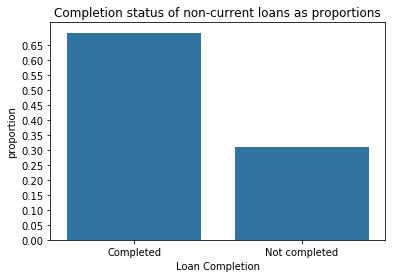

In [28]:
# Plot LoanCompleted column as %
base_color = sb.color_palette()[0]
n_points = loans.shape[0]
max_count = loans['LoanCompleted'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'LoanCompleted', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Loan Completion')
plt.title('Completion status of non-current loans as proportions');

We can see that close to 70% of the loans in the extracted data were completed and 30% were not completed (not paid off). This means that the mean rate of successful completion of loans in our filtered sample is 70%. I am interested to see if there are variables, or combinations of vaiables, that result in a completion status that is significantly different from 70%.

I'd like to check the distribution of some of the categorical variables next.

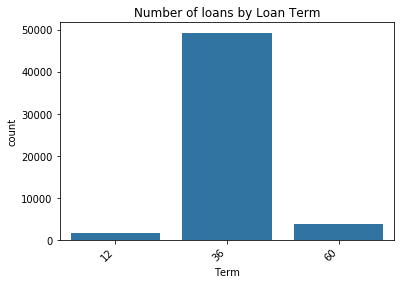

In [29]:
# Plot Term column
sb.countplot(data = loans, x = 'Term', color = base_color)
plt.xlabel('Term')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Number of loans by Loan Term');

The vast majoity of loans had a 36 month term, with 60 months being second most popular and 12 months third.

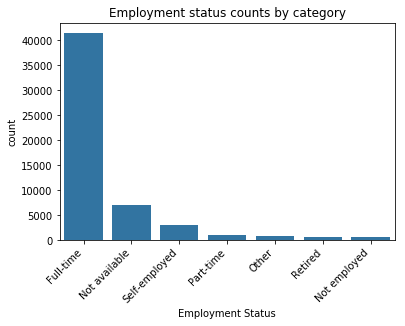

In [30]:
# Plot EmploymentStatus column
cat_order = loans['EmploymentStatus'].value_counts().index
sb.countplot(data = loans, x = 'EmploymentStatus', color = base_color, order=cat_order)
plt.xlabel('Employment Status')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Employment status counts by category');

We can see that most borrowers were involved in some form of employment, however, there was a large proportion for which the employment status was unknown. It will be interesting to see if being employed full-time increases the likelihood of a loan being paid off.

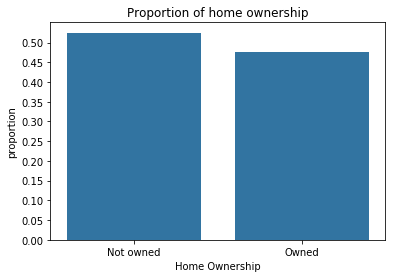

In [31]:
# Plot HomeOwnership column as %
n_points = loans.shape[0]
max_count = loans['HomeOwner'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'HomeOwner', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Home Ownership')
plt.xticks([0, 1], ['Not owned', 'Owned'])
plt.title('Proportion of home ownership');

Home ownership is split pretty evenly across the data with approximately 46% owning their home and the remaining 54% not owning their home.

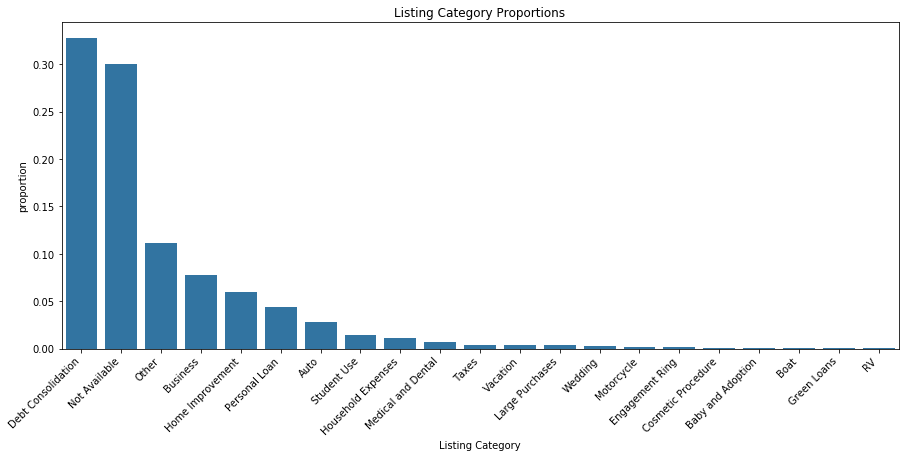

In [32]:
# Plot ListingCategory column as %
plt.figure(figsize=[15,6])
n_points = loans.shape[0]
cat_order = loans['ListingCategory'].value_counts().index
max_count = loans['ListingCategory'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'ListingCategory', color = base_color, order = cat_order)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Listing Category')
plt.xticks(rotation = 45, horizontalalignment='right')
plt.title('Listing Category Proportions');

Over a third of the Listing Categories fall under 'Debt Consolidation'. Another third is 'Not Available' and a large number are also 'Other' which is not very helpful for analysis. We may be able to look at the effect of the Debt Consolidation category on the outcome of a loan, however, most of the other categories are too underepresented to be able to draw reliable conclusions from.

Let's look at the Listing category proportions once 'Not available' is removed and the other Listing categories are combined.

In [33]:
# Drop loans with 'Not available' for ListingCategory
listing_categories = loans[loans['ListingCategory'] != 'Not Available']

# fuction to convert non-Debt consolidation values in ListingCategory to 'Other'
def convert_listing(listing):
    if listing == 'Debt Consolidation':
        return listing
    else:
        return 'Other'
    
listing_categories['ListingCategory'] = listing_categories['ListingCategory'].apply(convert_listing)
listing_categories.ListingCategory.value_counts()

C:\Users\Jeff\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Other                 20265
Debt Consolidation    17859
Name: ListingCategory, dtype: int64

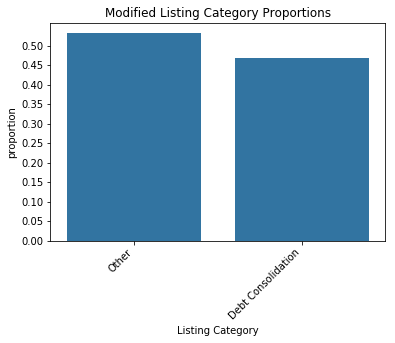

In [34]:
# Plot modified ListingCategory column as %
n_points = listing_categories.shape[0]
cat_order = listing_categories['ListingCategory'].value_counts().index
max_count = listing_categories['ListingCategory'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = listing_categories, x = 'ListingCategory', color = base_color, order = cat_order)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Listing Category')
plt.xticks(rotation = 45, horizontalalignment='right')
plt.title('Modified Listing Category Proportions');

Combining the ListingCategory values in this way we can see that around 45% are Debt consolidation and 55% are other listing categories. When I perform the bivariate analysis I can compare the impact of Debt consolidation on the overall outcome of a loan using these groupings.

Let's see if there are any trends in the Quarter the loans originated.

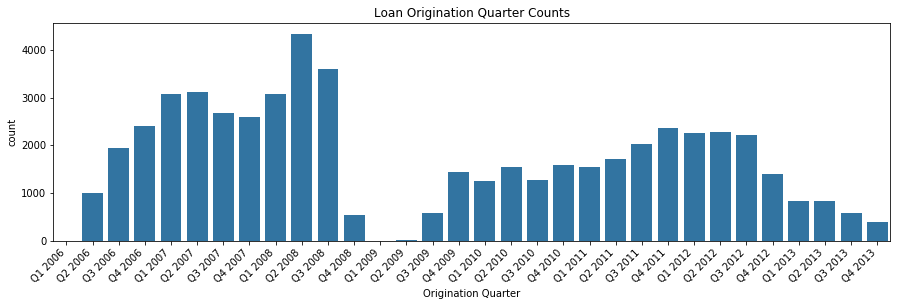

In [35]:
# Plot LoanOriginationQuarter column
plt.figure(figsize=[15,4])
quarter_order = ['Q1 2006','Q2 2006','Q3 2006','Q4 2006','Q1 2007','Q2 2007','Q3 2007','Q4 2007','Q1 2008','Q2 2008','Q3 2008',
             'Q4 2008','Q1 2009','Q2 2009','Q3 2009','Q4 2009','Q1 2010','Q2 2010','Q3 2010','Q4 2010','Q1 2011','Q2 2011',
             'Q3 2011','Q4 2011','Q1 2012','Q2 2012','Q3 2012','Q4 2012','Q1 2013','Q2 2013','Q3 2013','Q4 2013']
sb.countplot(data = loans, x = 'LoanOriginationQuarter', color = base_color, order=quarter_order)
plt.xlabel('Origination Quarter')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Loan Origination Quarter Counts');

While there is some variation in the number of loans per quarter, most quarters have between 1200 and 2500 loans. Q4 2008 to Q3 2009 have noticeably fewer loans. I will compare the number of loans in this period with the number in the original dataset to check that the earlier filtering has not skewed the origination quarters in the remaining data.

In [36]:
low_quarters = (loans['LoanOriginationQuarter'] == 'Q4 2008') |\
    (loans['LoanOriginationQuarter'] == 'Q1 2009') | (loans['LoanOriginationQuarter'] == 'Q2 2009') |\
    (loans['LoanOriginationQuarter'] == 'Q3 2009')
low_quarters.sum()

1130

Filtering the original dataset in Excel on the above quarters returned the same number of loans (1130). This means that the low number of loans in these quarters is an aspect of the original dataset and has not been caused by the filtering of the data completed in the data wrangling phase. There are no loans recorded from Q1 2006 and Q1 2009 in the data so I will remove these quarters from the quarter ordering.

In [37]:
quarter_order = ['Q2 2006','Q3 2006','Q4 2006','Q1 2007','Q2 2007','Q3 2007','Q4 2007','Q1 2008','Q2 2008','Q3 2008',
             'Q4 2008','Q2 2009','Q3 2009','Q4 2009','Q1 2010','Q2 2010','Q3 2010','Q4 2010','Q1 2011','Q2 2011',
             'Q3 2011','Q4 2011','Q1 2012','Q2 2012','Q3 2012','Q4 2012','Q1 2013','Q2 2013','Q3 2013','Q4 2013']

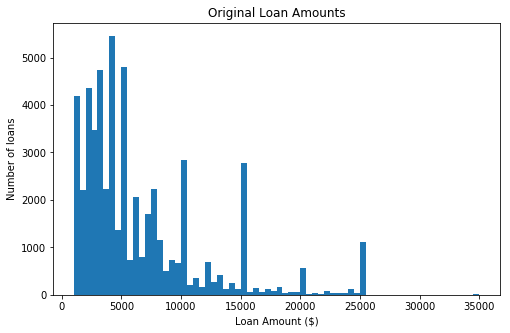

In [38]:
# Plot LoanOriginalAmount column
binsize = 500
bins = np.arange(loans['LoanOriginalAmount'].min(), loans['LoanOriginalAmount'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Loan Amount ($)')
plt.ylabel('Number of loans')
plt.title('Original Loan Amounts')
plt.show()

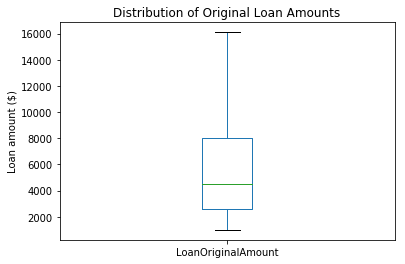

In [39]:
loans['LoanOriginalAmount'].plot(kind='box', showfliers=False)
plt.ylabel('Loan amount ($)')
plt.title('Distribution of Original Loan Amounts');

We can see that the majority of loans are for under \\$6000 although there are spikes at \\$10000, \\$15000, \\$20000 and \\$25000. This is probably due to people taking out loans that round out to a convenient figure (here at \\$5000 intervals). The median is around \\$4500 and most loans fall between \\$2000 and \\$8000.

Due to the long tail I can also plot the Original Loan amounts on a log scale.

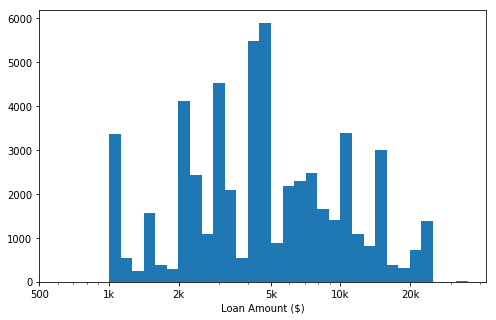

In [40]:
log_binsize = 0.05
bins = 10 ** np.arange(3, np.log10(loans['LoanOriginalAmount'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'LoanOriginalAmount', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Loan Amount ($)')
plt.show()

The Original Loan Amount has a long tail with most of the amounts being below \\$6000 and a few higher amounts, with large spikes at each interval of \\$5000. The log of the Original Loan Amount consists of several large spikes at each $1k log Loan Amount.

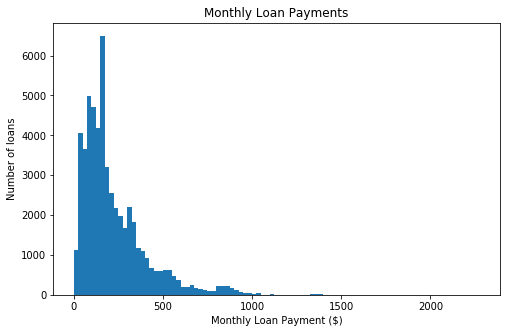

In [41]:
# Plot MonthlyLoanPayment column
binsize = 25
bins = np.arange(0, loans['MonthlyLoanPayment'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'MonthlyLoanPayment', bins = bins)
plt.xlabel('Monthly Loan Payment ($)')
plt.ylabel('Number of loans')
plt.title('Monthly Loan Payments')
plt.show()

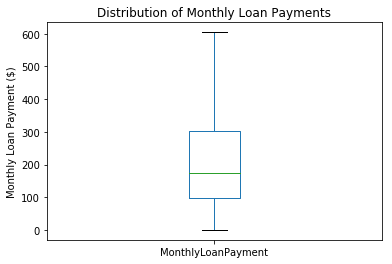

In [42]:
loans['MonthlyLoanPayment'].plot(kind='box', showfliers=False)
plt.ylabel('Monthly Loan Payment ($)')
plt.title('Distribution of Monthly Loan Payments');

We can see with the Monthly Loan Payments that they are also heavily right skewed. There is a spike around \\$200 per month and most payments are below \\$500 per month. Around half of the payments fall between \\$100 and \\$300.

I can plot a log scale of Monthly Loan Payments as it shows a long tail.

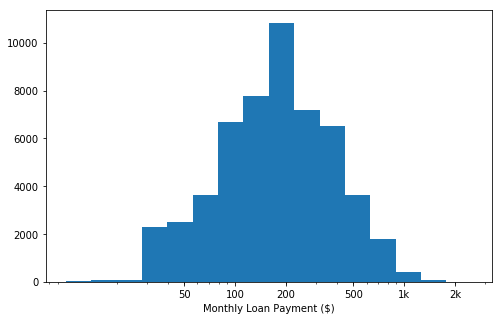

In [43]:
log_binsize = 0.15
bins = 10 ** np.arange(1, np.log10(loans['MonthlyLoanPayment'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'MonthlyLoanPayment', bins = bins)
plt.xscale('log')
plt.xticks([50, 100, 200, 500, 1000, 2000], [50, 100, 200, 500, '1k', '2k'])
plt.xlabel('Monthly Loan Payment ($)')
plt.show()

The Monthly Loan Payment has a long tail with most of the amounts being below \\$500 and a few higher amounts. The log of the Monthly Loan Payment shows a normal distibution with the median monthly payment being a bit under \\$200.

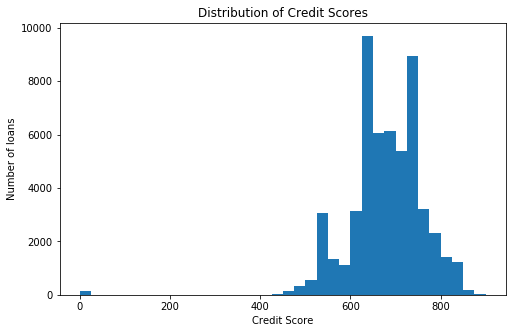

In [44]:
# Plot CreditScore column
binsize = 25
bins = np.arange(0, loans['CreditScore'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'CreditScore', bins = bins)
plt.xlabel('Credit Score')
plt.ylabel('Number of loans')
plt.title('Distribution of Credit Scores')
plt.show()

There are some Credit Scores that are close to 0. I will remove these outliers from this graph to get a clearer picture of the distribution of Credit Scores..

In [45]:
# Select borrowers with a credit score of 0
zero_score = loans['CreditScore'] < 50
zero_score.sum()

133

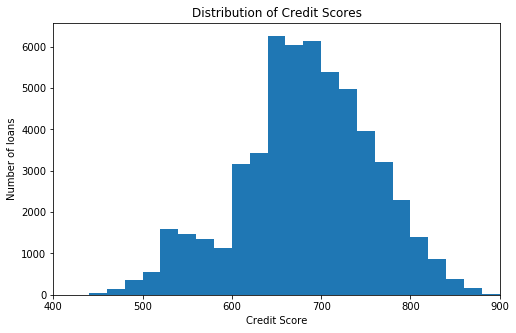

In [46]:
non_outliers = loans.loc[-zero_score,:]

# Plot revised CreditScore column
binsize = 20
bins = np.arange(0, non_outliers['CreditScore'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = non_outliers, x = 'CreditScore', bins = bins)
plt.xlabel('Credit Score')
plt.ylabel('Number of loans')
plt.title('Distribution of Credit Scores')
plt.xlim(400,900)
plt.show()

With the outlier credit scores removed we see that at the lower scores the data increases in spikes, levels out around 650 and then drops away fairly consistently to reach its max near 900.

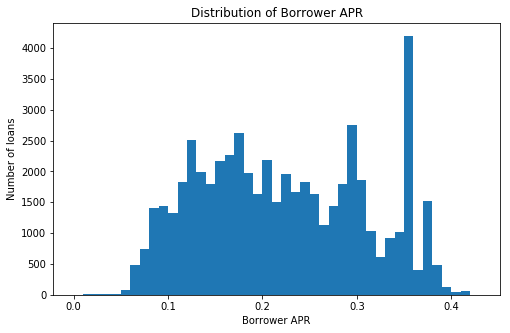

In [47]:
# Plot BorrowerAPR column
binsize = 0.01
bins = np.arange(0, loans['BorrowerAPR'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'BorrowerAPR', bins = bins)
plt.xlabel('Borrower APR')
plt.ylabel('Number of loans')
plt.title('Distribution of Borrower APR')
plt.show()

The borrower APR are fairly evenly spread between around 0.1 to 0.3 with a large spike at 0.36.

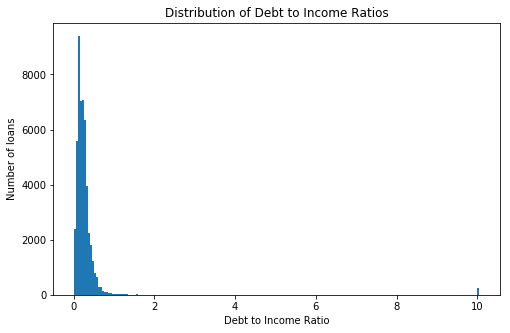

In [48]:
# Plot DebtToIncomeRatio column
binsize = 0.05
bins = np.arange(0, loans['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Number of loans')
plt.title('Distribution of Debt to Income Ratios')
plt.show()

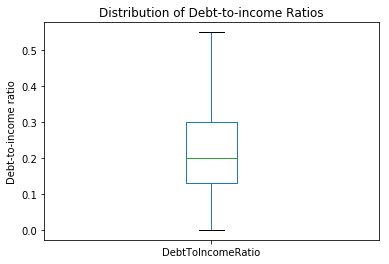

In [49]:
loans['DebtToIncomeRatio'].plot(kind='box', showfliers=False)
plt.ylabel('Debt-to-income ratio')
plt.title('Distribution of Debt-to-income Ratios');

There are a number of outliers above 10 (the highest allowed ratio) which make the graph difficult to read. I will remove these and plot the graph again.

In [50]:
outliers = loans['DebtToIncomeRatio'] > 9.5
outliers.sum()

248

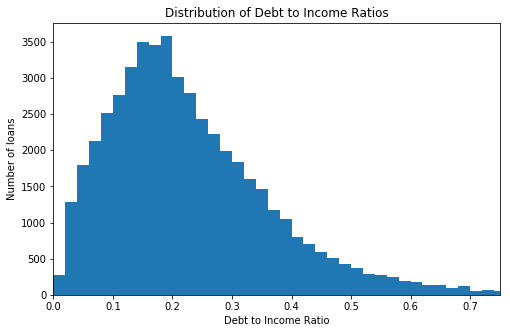

In [51]:
without_outliers = loans.loc[-outliers,:]

# Replot DebtToIncomeRatio column
binsize = 0.02
bins = np.arange(0, without_outliers['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = without_outliers, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Number of loans')
plt.title('Distribution of Debt to Income Ratios')
plt.xlim(0,0.75)
plt.show()

Here we can see that the distribution is skewed to the right with most of the ratios being below 0.5. The majority of ratios are between 0.1 and 0.3. I will keep the outliers in the loan data as I want to know if these high debt-to-income ratios affect loan outcome.

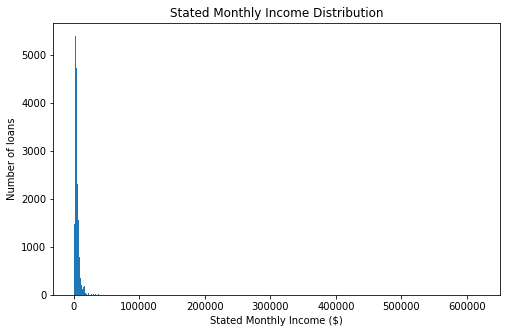

In [52]:
# Plot StatedMonthlyIncome column
binsize = 500
bins = np.arange(0, loans['StatedMonthlyIncome'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'StatedMonthlyIncome', bins = bins)
plt.xlabel('Stated Monthly Income ($)')
plt.ylabel('Number of loans')
plt.title('Stated Monthly Income Distribution')
plt.show()

Here we can see again a few outliers have made the graph of Stated Monthly Income very difficult to interpret. Let's try removing these outliers.

In [53]:
income_outliers = loans['StatedMonthlyIncome'] > 30000
income_outliers.sum()

142

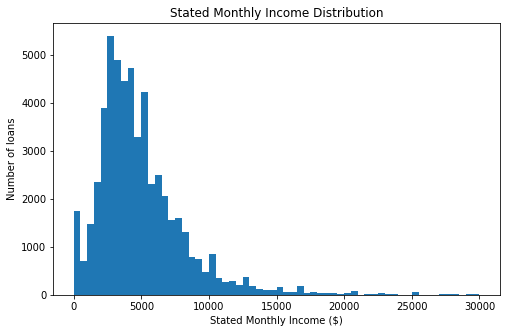

In [54]:
without_outliers = loans.loc[-income_outliers,:]

# Replot the StatedMonthlyIncome graph
binsize = 500
bins = np.arange(0, without_outliers['StatedMonthlyIncome'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = without_outliers, x = 'StatedMonthlyIncome', bins = bins)
plt.xlabel('Stated Monthly Income ($)')
plt.ylabel('Number of loans')
plt.title('Stated Monthly Income Distribution')
plt.show()

The plot now shows a right skew with most of the borrowers earning less than \\$10000 per month. There are a large number of borrowers that do not appear to have any stated income. I want to check if they are missing other data that suggests that they are missing the income rather than not earning any income.

In [55]:
no_income = loans[loans['StatedMonthlyIncome'] == 0]
no_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099 entries, 78 to 113803
Data columns (total 16 columns):
Term                      1099 non-null category
BorrowerAPR               1099 non-null float64
ListingCategory           1099 non-null category
EmploymentStatus          1099 non-null category
HomeOwner                 1099 non-null bool
TotalCreditLines          1095 non-null float64
TotalDelinquencies        1093 non-null float64
DebtToIncomeRatio         11 non-null float64
StatedMonthlyIncome       1099 non-null float64
LoanNumber                1099 non-null object
LoanOriginalAmount        1099 non-null int64
LoanOriginationQuarter    1099 non-null category
MemberKey                 1099 non-null object
MonthlyLoanPayment        1099 non-null float64
LoanCompleted             1099 non-null category
CreditScore               1099 non-null float64
dtypes: bool(1), category(5), float64(7), int64(1), object(2)
memory usage: 103.7+ KB


In [56]:
no_income.head(10)

,Term,BorrowerAPR,ListingCategory,EmploymentStatus,HomeOwner,TotalCreditLines,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LoanCompleted,CreditScore
78,36,0.18454,Business,Full-time,True,26.0,0.0,NaN,0.0,33852,4800,Q3 2008,D77734052911579724BCDD5,171.13,Not completed,729.5
100,36,0.35356,Household Expenses,Not employed,False,10.0,0.0,NaN,0.0,82947,4000,Q1 2013,CEE83539008163122ED9B62,172.76,Not completed,729.5
108,36,0.28320,Debt Consolidation,Full-time,False,21.0,0.0,NaN,0.0,30830,14000,Q2 2008,34F93419082777341558B78,564.07,Completed,649.5
170,36,0.28851,Other,Not employed,True,16.0,0.0,NaN,0.0,63781,10000,Q2 2012,0B3A35450946276237DF676,397.55,Completed,769.5
186,36,0.35797,Home Improvement,Not employed,False,43.0,83.0,NaN,0.0,60674,4000,Q1 2012,A2603539184865789204203,173.71,Not completed,669.5
332,36,0.25650,Not Available,Not available,True,18.0,NaN,0.10361,0.0,668,1000,Q2 2006,4E95336440121524707AE42,39.10,Not completed,529.5
335,36,0.35797,Other,Not employed,False,3.0,0.0,NaN,0.0,62667,2000,Q1 2012,F1F735415698555052DA0DF,86.85,Completed,769.5
688,36,0.30532,Other,Not employed,False,22.0,0.0,NaN,0.0,51593,2500,Q3 2011,E1583504823481507B7F8A0,102.05,Completed,729.5
772,36,0.10491,Debt Consolidation,Full-time,True,25.0,0.0,NaN,0.0,29671,3500,Q2 2008,33313390658251495A144FE,112.61,Completed,829.5
917,36,0.15713,Not Available,Not available,True,17.0,0.0,NaN,0.0,2552,8000,Q3 2006,4D1333648643890119C04A5,274.24,Completed,729.5


There are 1099 loans that have a stated monthly income of \\$0. Looking at these loans there is no obvious data missing or patterns to the data (e.g. all from specific quarters). The debt-to-income-ratio is missing for most of them, but given that their income is stated as 0 this makes sense. While it is difficult to believe a loan would be given to a borrower with no income, I do not have anything to suggest that these rows are inaccurate so I will keep them in the data.

There appears from the graph of Stated Monthly Income that there are around 1800 loans with Stated Monthly Income less than \\$500 so I should check the other low values.

In [57]:
# Find loans below $500 per month of stated monthly income
low_income =  loans[loans['StatedMonthlyIncome'] < 500]
# Remove loans of $0 per month stated monthly income
low_income =  low_income[low_income['StatedMonthlyIncome'] != 0]
low_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 645 entries, 42 to 113626
Data columns (total 16 columns):
Term                      645 non-null category
BorrowerAPR               645 non-null float64
ListingCategory           645 non-null category
EmploymentStatus          645 non-null category
HomeOwner                 645 non-null bool
TotalCreditLines          631 non-null float64
TotalDelinquencies        626 non-null float64
DebtToIncomeRatio         568 non-null float64
StatedMonthlyIncome       645 non-null float64
LoanNumber                645 non-null object
LoanOriginalAmount        645 non-null int64
LoanOriginationQuarter    645 non-null category
MemberKey                 645 non-null object
MonthlyLoanPayment        645 non-null float64
LoanCompleted             645 non-null category
CreditScore               645 non-null float64
dtypes: bool(1), category(5), float64(7), int64(1), object(2)
memory usage: 62.1+ KB


In [58]:
low_income.head(10)

,Term,BorrowerAPR,ListingCategory,EmploymentStatus,HomeOwner,TotalCreditLines,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LoanCompleted,CreditScore
42,36,0.30300,Not Available,Not available,False,20.0,3.0,0.27,416.666667,7286,1500,Q1 2007,5CCA33798155110380A1C68,62.86,Not completed,529.5
146,36,0.09939,Not Available,Not available,False,8.0,0.0,0.07,0.083333,2902,4000,Q3 2006,862A3365213342789F57EB7,127.66,Completed,749.5
184,36,0.26590,Not Available,Not available,False,3.0,2.0,0.49,200.000000,4846,1200,Q4 2006,9C4B337401069034703BFF6,47.71,Not completed,489.5
226,36,0.11749,Not Available,Full-time,True,47.0,0.0,10.01,0.083333,8239,1000,Q1 2007,0E243382750780180A98377,32.27,Completed,609.5
576,36,0.10505,Not Available,Retired,False,13.0,0.0,10.01,0.083333,13269,1500,Q2 2007,574C3374106242551D3C75E,47.94,Completed,809.5
794,36,0.29776,Not Available,Not available,False,NaN,NaN,NaN,115.583333,7697,4000,Q1 2007,60493379289275032D64C21,167.62,Completed,9.5
895,36,0.35797,Household Expenses,Self-employed,True,50.0,0.0,NaN,14.583333,59893,4000,Q1 2012,EDCB35372434759063A6711,173.71,Not completed,709.5
1242,36,0.11415,Not Available,Not employed,False,12.0,0.0,10.01,0.083333,16053,3000,Q2 2007,C4C33365996309580AFAC5C,97.82,Completed,749.5
1356,36,0.14982,Debt Consolidation,Part-time,False,5.0,12.0,3.49,48.333333,28751,1450,Q1 2008,085E3414289581697F4FC40,48.74,Completed,529.5
1544,36,0.29205,Business,Part-time,False,5.0,0.0,0.14,416.666667,37539,1000,Q4 2008,F3D3343273718063869EBAE,38.87,Not completed,589.5


Again there is no clear pattern to the low income loans that suggests that the data is inaccurate. I can see several Stated Monthly Income values of \\$0.083333 so I will check the value counts on the column to look for anything of interest.

In [59]:
low_income.StatedMonthlyIncome.value_counts().head()

0.083333      242
416.666667     41
250.000000     19
166.666667     16
208.333333     15
Name: StatedMonthlyIncome, dtype: int64

There are 242 borrowers with a Stated Monthly Income of \\$0.083333. This equates to about \\$1 per year which does not seem accurate, especially for someone who is listed as employed. I will remove these loans from any analysis involving the Stated monthly Income as I am not confident in their accuracy.

In [60]:
# Remove loans where Stated Monthly Income = $0.083333
incorrect_income = loans['StatedMonthlyIncome'] == 0.083333
filtered_income = loans.loc[-incorrect_income,:]

In [61]:
filtered_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54243 entries, 0 to 113935
Data columns (total 16 columns):
Term                      54243 non-null category
BorrowerAPR               54243 non-null float64
ListingCategory           54243 non-null category
EmploymentStatus          54243 non-null category
HomeOwner                 54243 non-null bool
TotalCreditLines          54143 non-null float64
TotalDelinquencies        53855 non-null float64
DebtToIncomeRatio         50032 non-null float64
StatedMonthlyIncome       54243 non-null float64
LoanNumber                54243 non-null object
LoanOriginalAmount        54243 non-null int64
LoanOriginationQuarter    54243 non-null category
MemberKey                 54243 non-null object
MonthlyLoanPayment        54243 non-null float64
LoanCompleted             54243 non-null category
CreditScore               54243 non-null float64
dtypes: bool(1), category(5), float64(7), int64(1), object(2)
memory usage: 4.9+ MB


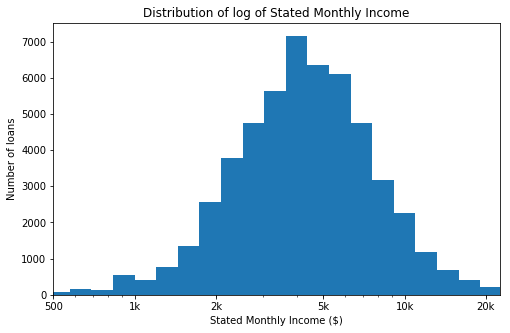

In [62]:
log_binsize = 0.08
bins = 10 ** np.arange(1, np.log10(filtered_income['StatedMonthlyIncome'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = filtered_income, x = 'StatedMonthlyIncome', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Stated Monthly Income ($)')
plt.xlim(500, 22500)
plt.ylabel('Number of loans')
plt.title('Distribution of log of Stated Monthly Income')
plt.show()

With a log transformation the Stated Monthly Income looks normal with the mean being a little under \\$5000.

We can look at the distribution of the number of loans per borrower by grouping by the MemberKey.

In [63]:
# Create a DataFrame holding the counts of loans per MemberKey
members = loans.groupby('MemberKey').size().reset_index(name='counts')

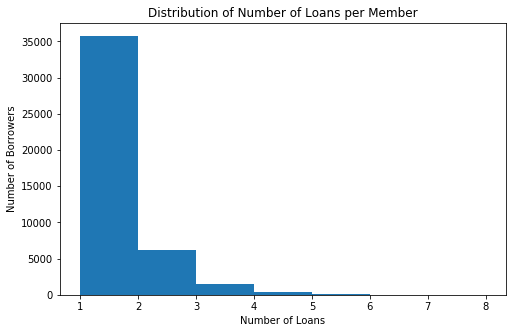

In [64]:
binsize = 1
bins = np.arange(1, members['counts'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = members, x = 'counts', bins = bins)
plt.xlabel('Number of Loans')
plt.ylabel('Number of Borrowers')
plt.title('Distribution of Number of Loans per Member')
plt.show()

We can also look at the proportion of number of loans per borrower.

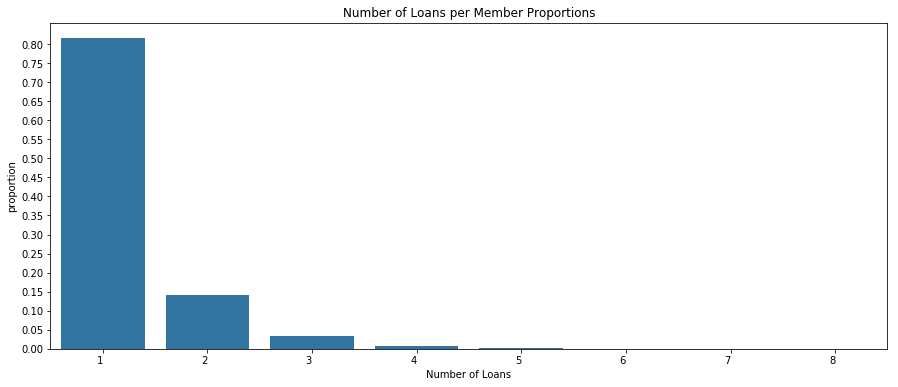

In [65]:
# Plot Loan counts column as %
plt.figure(figsize=[15,6])
n_points = members.shape[0]
cat_order = [1, 2, 3, 4, 5, 6, 7, 8]
max_count = members['counts'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
ax = sb.countplot(data = members, x = 'counts', color = base_color, order = cat_order)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Number of Loans')
plt.xticks(horizontalalignment='right')
plt.title('Number of Loans per Member Proportions')
plt.show();

We can see from this that most (80%) of borrowers have only one finished loan, whether it was completed succesfully or not. A further 14% have two finished loans and around 4% have three. The highest number of finished loans is 8.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

70% of the loans were completed succesfully and 30% were not. Home ownership was split fairly evenly and most borrowers had one completed loan (80%) with 15% with 2 completed loans and around 4% with three. The original loan amounts were skewed to the right and tended to cluster around \\$5000 intervals suggesting that borrowers would take out a loan that was an interval of \\$5000. Monthly loan payments were also skewed to the right, however, after a log transformation these showed a normal distribution. Most monthly payments were below \\$500 with the average being around \\$200.

The Debt-to-income ratios were clearly right skewed with most being below 0.5. Listing Categories had a large number of Unknown and Other listings which make the feature less useful for analysis. Over a third were listed as Debt Consolidation so there is the possibility to look at the effect of Debt Consolidation on Loan Outcome Status compared to the other Listing Categories.

There was variation in the Loan Quarter Originations and a noticeable lack of loans generated between Q4 2008 and Q4 2009. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Some work was required to tidy the data. As I am investigating the impact of features on Loan Outcome Status, I needed to remove loans which had not yet reached an outcome (paid off or not paid off). I chose to include Defaulted loans in the not paid off category as there were a large number of them and they are loans that Prosper consider to be unlikely to be paid off. Loans that were past due were removed as I still considered these as current as there was a reasonable chance they may be paid off, as opposed to the defaulted loans.

There were a few loans that were duplicated in the data. The only difference between duplicated loans was the value in the ProsperScore column. I am not going to use this column in my analysis so it is safe to remove duplicates and keep only the first (the default action) as this will not affect my analysis in any way.

The EmploymentStatus column was not very helpful as it contained a large number of 'Employed' results, but then had separate levels of employment in the data also. I addressed this by converting 'Employed' members to 'Full-time' due to the fact that most employed members were in the 'Full-time' category.

There were outliers at the low end for Credit Score which I removed to make the plots clearer. Each of these had a low score of 0 and an upper score of 19, which may reflect errors in the data. There were also outliers at the high end for Stated Monthly Income. I removed those that were above \\$30000 per month from the analysis to make the plots clearer. It is also reasonable to expect that some of these high values were inaccurate when considering the relatively small loan amounts they were for.

Several columns were converted to category types as these were appropriate to the form of the data (each contained clear categories). There were several entries that were missing data for a number of columns so I removed these. A small number of rows were missing the BorrowerAPR so replaced these with the mean for the column, as it was a very small percentage of rows that it was missing from. There were a number of loans with a Stated Monthly Income of around $1 per year which I removed for analysis based on Stated Monthly Income.

## Bivariate Exploration

I'll start by looking at the pairwise correlations present between features in the data.

In [66]:
numeric_vars = ['BorrowerAPR', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanOriginalAmount', 'MonthlyLoanPayment',
                'CreditScore']
categoric_vars = ['Term', 'ListingCategory', 'EmploymentStatus', 'LoanOriginationQuarter', 'LoanCompleted']

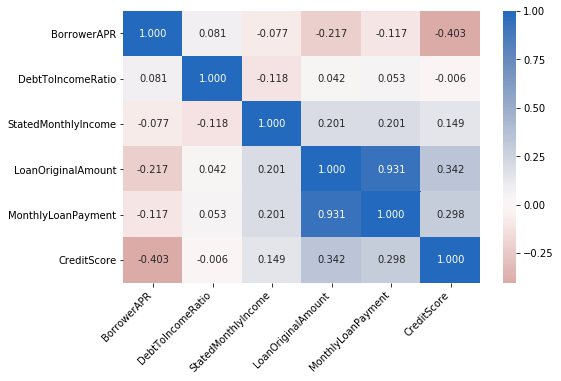

In [67]:
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(filtered_income[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.xticks(rotation = 45, horizontalalignment='right')
plt.show()

The correlations are largely what we would expect for this data:

- BorrowerAPR correlates closest with CreditScore (lower credit score = higher borrower APR)
- Monthly loan payments increase as the Loan Original Amount increases

The correlation scores between the other numeric variables were not high enough to suggest a correlation. Debt-to-income ratios showed the least correlation to any other numeric variable. There does not appear to be any interesting relationships between the numeric variables worth examining further - the only clear relationship is between Loan Original Amount and Monthly Loan Payment which we would expect to be correlated.

Next I will look at how Loan Completion Status is affected by Term, Employment Status and Loan Origination Quarter.

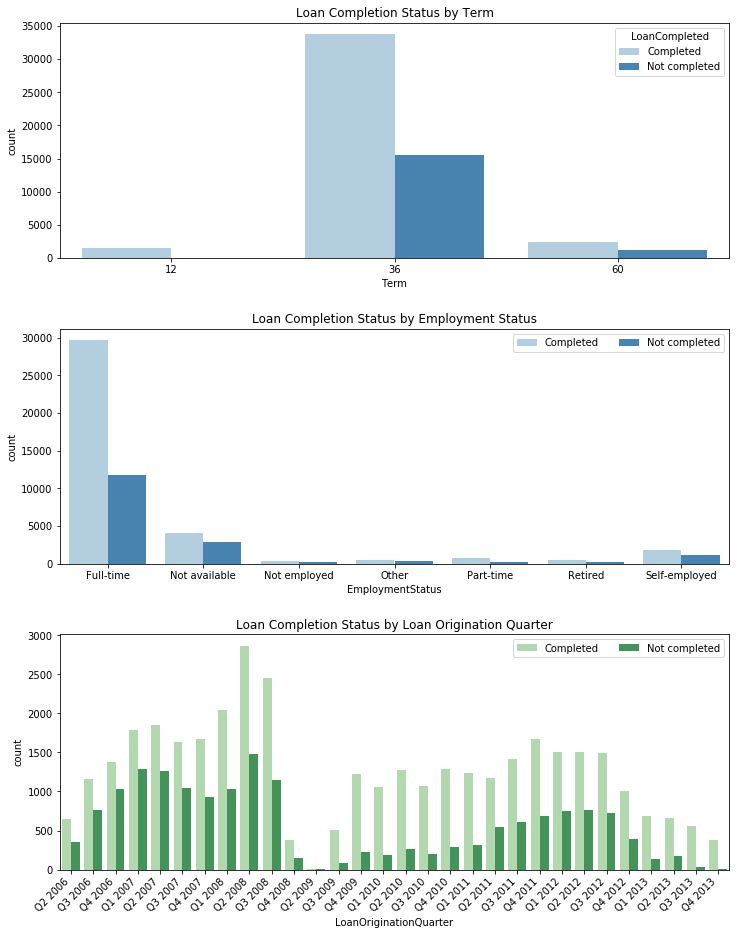

In [68]:
# Plot LoanCompleted against categorical variables
plt.figure(figsize = [12, 12])
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3)

# subplot 1: Term vs LoanCompleted
plt.subplot(3, 1, 1)
sb.countplot(data = loans, x = 'Term', hue = 'LoanCompleted', palette = 'Blues')
plt.title('Loan Completion Status by Term')

# subplot 2: EmploymentStatus vs. LoanCompleted
ax = plt.subplot(3, 1, 2)
sb.countplot(data = loans, x = 'EmploymentStatus', hue = 'LoanCompleted', palette = 'Blues')
ax.legend(ncol = 2) # re-arrange legend to reduce overlapping
plt.title('Loan Completion Status by Employment Status')

# subplot 3: ListingOrigniationQuarter vs. LoanCompleted, use different color palette
ax = plt.subplot(3, 1, 3)
sb.countplot(data = loans, x = 'LoanOriginationQuarter', hue = 'LoanCompleted', palette = 'Greens', order = quarter_order)
plt.xticks(rotation = 45, horizontalalignment='right')
ax.legend(loc = 1, ncol = 2) # re-arrange legend to remove overlapping
plt.title('Loan Completion Status by Loan Origination Quarter')

plt.show()

The graphs above show that there is some variance in Loan Completion Status between the different variables. I will look at each of these in more detail to see what they suggest.

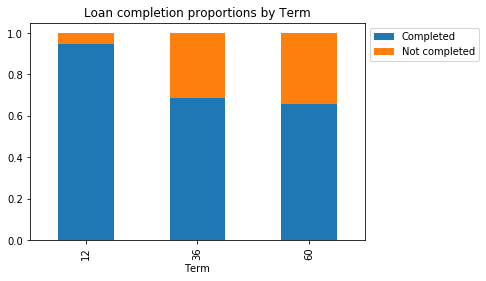

In [69]:
term_props = loans.groupby('Term')['LoanCompleted'].value_counts(normalize=True).unstack()
term_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Term').legend(bbox_to_anchor=(1, 1));

In [70]:
term_props

LoanCompleted,Completed,Not completed
Term,,
12,0.946475,0.053525
36,0.685634,0.314366
60,0.655471,0.344529


We can see here that loans with a twelve month term are mostly completed (95%). Loans over 36 and 60 months have a much lower completion rate (69% and 66% respectively).

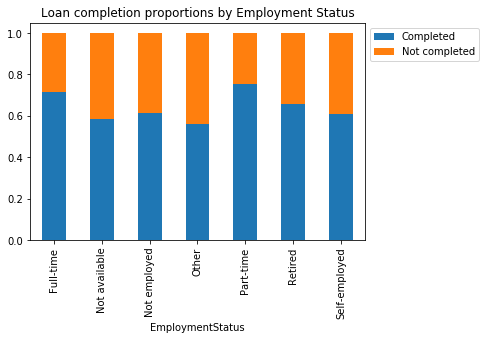

In [71]:
# Compare Loan Outcome Status and Employment
employment_props = loans.groupby('EmploymentStatus')['LoanCompleted'].value_counts(normalize=True).unstack()
employment_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Employment Status').legend(
    bbox_to_anchor=(1, 1));

In [72]:
employment_props.sort_values('Completed', ascending=False)

LoanCompleted,Completed,Not completed
EmploymentStatus,,
Part-time,0.751894,0.248106
Full-time,0.717161,0.282839
Retired,0.658537,0.341463
Not employed,0.613191,0.386809
Self-employed,0.609231,0.390769
Not available,0.584795,0.415205
Other,0.562657,0.437343


Borrowers who are employed (either part- or full-time) are the most likely to complete their loan (75% and 72% respectively) while those for whom employment status is not available (Not available and Other) are the least likely to pay the loan, at 59% and 56% repectively.

Trying to group by LoanOriginationQuarter returns an error that suggests there are empty categories. I need to check the value counts for each category given that I have filtered out certain data in earlier steps.

In [73]:
loans.LoanOriginationQuarter.value_counts().tail()

Q4 2013    381
Q1 2014     68
Q2 2009     13
Q4 2005      0
Q1 2006      0
Name: LoanOriginationQuarter, dtype: int64

Q4 2005 and Q1 2006 are both empty and therefore causing the error. I will remove them from the data.

In [74]:
loans.LoanOriginationQuarter.cat.remove_unused_categories(inplace=True)

In [75]:
loans.LoanOriginationQuarter.value_counts().tail()

Q3 2009    585
Q4 2008    532
Q4 2013    381
Q1 2014     68
Q2 2009     13
Name: LoanOriginationQuarter, dtype: int64

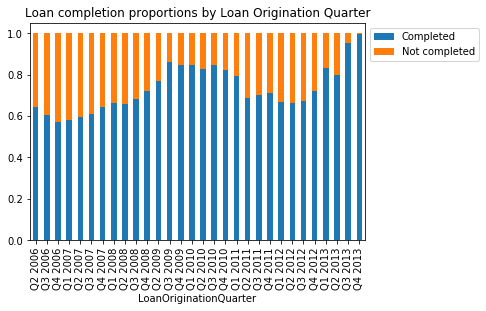

In [76]:
# Compare Loan Outcome Status and Loan Origination Quarter
quarter_props = loans.groupby('LoanOriginationQuarter')['LoanCompleted'].value_counts(normalize=True).unstack().reindex(
    quarter_order)
quarter_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Loan Origination Quarter').legend(
    bbox_to_anchor=(1, 1));

The earliest loans from Q2 2006 to Q4 2008 had the lowest completion rates, though they generally increased from Q4 2006 to a peak at Q3 2009. From Q3 2010 they trended downward to plateau at Q1 2012 before increasing again from Q4 2012 with the latest loans from 2013 having the highest completion rates.

I'd like to see if there is a relationship between Listing Category and Loan Completion.

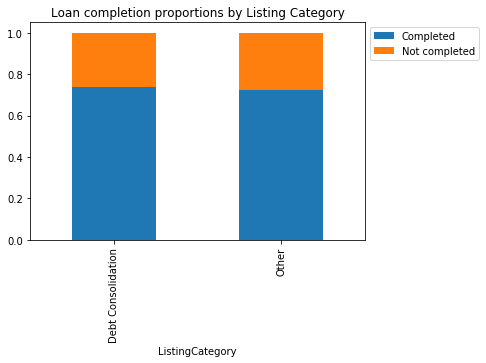

In [77]:
# Compare Loan Outcome Status and Loan Category
listing_props = listing_categories.groupby('ListingCategory')['LoanCompleted'].value_counts(normalize=True).unstack()
listing_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Listing Category').legend(
    bbox_to_anchor=(1, 1));

There is no difference in Loan copletion status between Debt consolidation and all other categories grouped together. I'll check if there are any differences between individual categories.

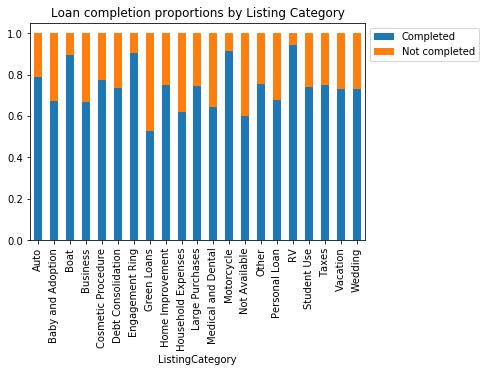

In [78]:
# Compare Loan Outcome Status and Loan Category
listing_props = loans.groupby('ListingCategory')['LoanCompleted'].value_counts(normalize=True).unstack()
listing_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Listing Category').legend(
    bbox_to_anchor=(1, 1));

There is some more variation visible now, with RV loans bieng mostly completed and only around half of Green Loans being completed. Boat, Engagement Rings and Motorcycles had high completion rates while household expenses, Not available Personal loans had lower completion rates.

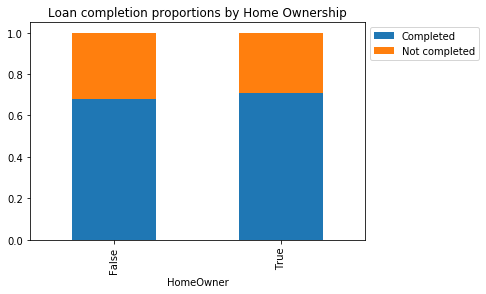

In [79]:
# Compare Loan Outcome Status and Home Ownership
# See if can plot several categorical variables in one set to look for ones that are interesting
home_props = loans.groupby('HomeOwner')['LoanCompleted'].value_counts(normalize=True).unstack()
home_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Home Ownership').legend(
    bbox_to_anchor=(1, 1));

In [80]:
home_props

LoanCompleted,Completed,Not completed
HomeOwner,,
False,0.677202,0.322798
True,0.706089,0.293911


There is only a 3% difference in the rate of loan completion between home owners and non-owners, much smaller than the difference for employed versus non-employed or 12 month terms and 36 or 60 month terms.

The Debt-to-income ratios need to be binned before they can be analysed effectively. To do so I will add a DebtRatioBin column with the bin for each loan.

In [81]:
# Function to place Debt-To-Income-Ratio into bins
def get_ratio(debt_to_income):
    """Get bin for debt-to-income ratio."""
    if debt_to_income < 0.05:
        return 0.05
    elif debt_to_income < 0.1:
        return 0.1
    elif debt_to_income < 0.15:
        return 0.15
    elif debt_to_income < 0.2:
        return 0.2
    elif debt_to_income < 0.25:
        return 0.25
    elif debt_to_income < 0.3:
        return 0.3
    elif debt_to_income < 0.4:
        return 0.4
    elif debt_to_income < 0.5:
        return 0.5
    elif debt_to_income < 0.6:
        return 0.6
    elif debt_to_income < 0.7:
        return 0.7
    elif debt_to_income < 0.8:
        return 0.8
    elif debt_to_income <0.9:
        return 0.9
    elif debt_to_income < 1:
        return 1
    elif debt_to_income < 3:
        return 3
    elif debt_to_income < 6:
        return 6
    else:
        return 10
    
# Create a column placing Debt-to-income-ratio into a bin
loans['DebtRatioBin'] = loans.DebtToIncomeRatio.apply(get_ratio)

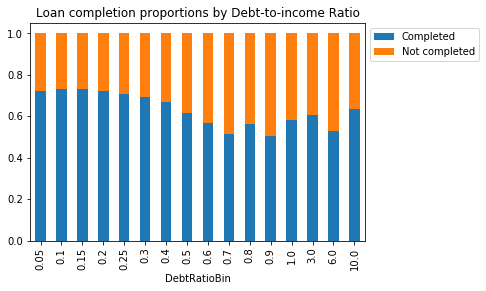

In [82]:
# Compare Loan Outcome Status and Debt Consolidation
debt_props = loans.groupby('DebtRatioBin')['LoanCompleted'].value_counts(normalize=True).unstack()
debt_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Debt-to-income Ratio').legend(
    bbox_to_anchor=(1, 1));

In [83]:
debt_props

LoanCompleted,Completed,Not completed
DebtRatioBin,,
0.05,0.720533,0.279467
0.10,0.731520,0.268480
0.15,0.730317,0.269683
0.20,0.721528,0.278472
0.25,0.707808,0.292192
0.30,0.694604,0.305396
0.40,0.670362,0.329638
0.50,0.616776,0.383224
0.60,0.569028,0.430972


Loan completion rates are fairly consistent between Debt-to-income ratios of 0 and 0.25 where they are around 72%. From 0.3 onwards they begin to trend down with a slight increase at 0.8 and again at 3 and 10.

Due to the close correlation between Loan Original Amount and Monthly Loan Payments, we only need to analyse one of these. We can look at the effect of Monthly Loan Payments.

C:\Users\Jeff\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


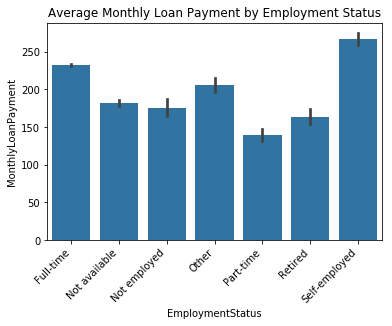

In [84]:
# Compare Employment Status and Monthly Loan Payment
base_color = sb.color_palette()[0]
sb.barplot(data = loans, x = 'EmploymentStatus', y='MonthlyLoanPayment',color=base_color).set_title(
    'Average Monthly Loan Payment by Employment Status')
plt.xticks(rotation=45, horizontalalignment='right');

The highest monthly payments on average were made by people that were self-employed or working full time. Lower monthly payments on average were made by borrowers that were not employed, retired or employed part-time. This would likely be a reflection of the ability of the borrower to pay back the loan given their monthly income.

To plot the effect of Monthly Loan Payments on Loan Completion I must first add a column that bins the Monthly Loan Payment values.

In [85]:
# Function to place Monthly Loan Payments into bins
def get_monthly_bin(monthly_payment):
    """Get bin for Monthly Loan Payment."""
    if monthly_payment == 0:
        return 0
    elif monthly_payment < 50:
        return 50
    elif monthly_payment < 100:
        return 100
    elif monthly_payment < 150:
        return 150
    elif monthly_payment < 200:
        return 200
    elif monthly_payment < 250:
        return 250
    elif monthly_payment < 300:
        return 300
    elif monthly_payment < 350:
        return 350
    elif monthly_payment < 400:
        return 400
    elif monthly_payment < 450:
        return 450
    elif monthly_payment < 500:
        return 500
    elif monthly_payment < 550:
        return 550
    elif monthly_payment < 600:
        return 600
    elif monthly_payment < 750:
        return 750
    elif monthly_payment < 1000:
        return 1000
    elif monthly_payment < 1500:
        return 1500
    elif monthly_payment < 2000:
        return 2000
    else:
        return 2500
    
# Create a column placing Debt-to-income-ratio into a bin
loans['MonthlyPaymentBin'] = loans.MonthlyLoanPayment.apply(get_monthly_bin)

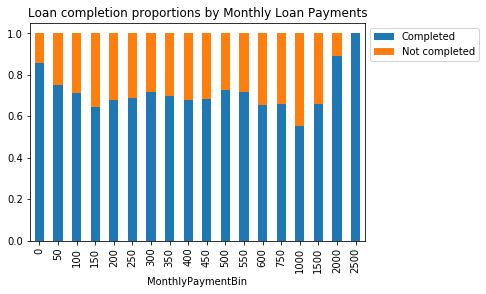

In [86]:
# Compare Loan Outcome Status and Debt Consolidation
monthly_props = loans.groupby('MonthlyPaymentBin')['LoanCompleted'].value_counts(normalize=True).unstack()
monthly_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Monthly Loan Payments').legend(
    bbox_to_anchor=(1, 1));

The completion rates according to monthly loan payments are fairly consistent. The few bins that showed different results were those at 0 and those above \\$1500 per month. Monthly Loan Payments between \\$750 and \\$1000 had the lowest rate of completion.

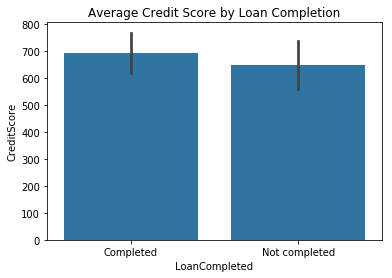

In [87]:
# Compare Loan Outcome Status and Credit Scores
sb.barplot(data = loans, x = 'LoanCompleted', y = 'CreditScore', color = base_color, ci = 'sd').set_title(
    'Average Credit Score by Loan Completion');

The average credit score for a completed loan was a bit higher than for non-completed loans at close to 700 compared to 650 for non-completed.

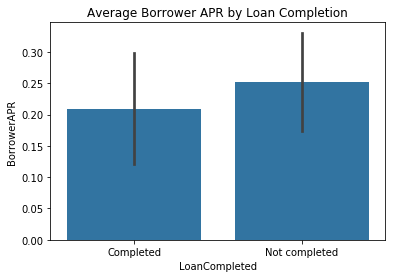

In [88]:
# Compare Loan Outcome Status and BorrowerAPR
sb.barplot(data = loans, x = 'LoanCompleted', y = 'BorrowerAPR', color = base_color, ci = 'sd').set_title(
    'Average Borrower APR by Loan Completion');

On average a completed loan has a lower Borrower APR at just over 0.2 than a non-completed loan at 0.25.

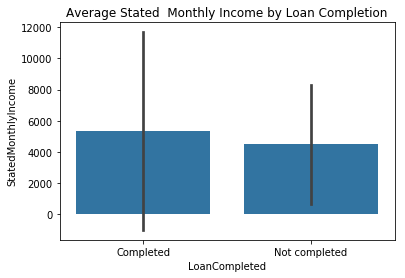

In [89]:
# Compare Loan Outcome Status and Stated Monthly Income
sb.barplot(data = filtered_income, x = 'LoanCompleted', y = 'StatedMonthlyIncome', color = base_color, ci = 'sd').set_title(
    'Average Stated  Monthly Income by Loan Completion');

The stated monthly income was on average higher for completed loans (at \\$5500) than non-completed at a little over \\$4000. There was a number of outliers in the Stated Monthly Income that skewed this data somewhat, however.

I will finish my bivariate analysis by looking for relationships between Employment status and the financial variables.

C:\Users\Jeff\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


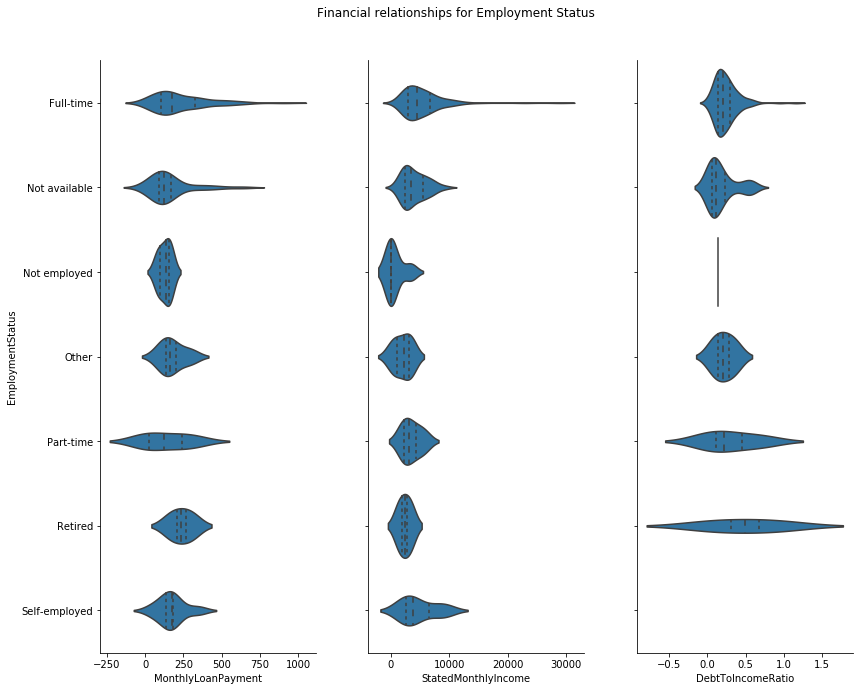

In [90]:
samples = np.random.choice(loans.shape[0], 500, replace = False)
loan_samples = filtered_income.loc[samples,:]

g = sb.PairGrid(data=loan_samples, x_vars = ['MonthlyLoanPayment', 'StatedMonthlyIncome', 'DebtToIncomeRatio'],
               y_vars=['EmploymentStatus'])
g.fig.set_figheight(12)
g.fig.set_figwidth(12)
g.fig.suptitle('Financial relationships for Employment Status')
g.map(sb.violinplot, inner = 'quartile');

Not employed members have zero income which also means they do not have any values for their Debt-to-income ratio. The income spread for Full-time and not-available is similar, with the exception of the long tail which shows some high values for a few full-time members. The Self-employed show the largest range as they are very spread out for Monthly Loan Payment and Stated Monthly income.

Part-time members have reduced Stated Monthly Income which is also reflected in a limited range for Monthly Loan payments. This can also be explained by the low number of members in the Part-time category. Retired members have a very low range of Monthly Loan Payments although their Stated Monthly Income spreads further.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

The term length appeared to have an impact on Loan completion, as a 12-month term had a high completion rate and 36-month and 60-month were each lower than the previous. Employed members were most likely to pay off their loans. There were some trends in the Loan Origination Quarter, as loans that originated between 2009 and 2010, and those from 2013 were the most likely to be paid off. Home ownership did not appear to impact the likelihood of a loan being paid off. 

There were some clear trends between the financial variables and Loan completion. Completion rates trended down as the Debt-to-income ratio increased. The average credit score was higher for members that completed their loans compared to those that did not. The Borrower APR was lower for those that completed their loans. The average stated monthly income was also higher for those that completed their loans.

The completion rate for Debt consolidation loans was no different from the completion rate for all other categories, however, there were some differences identified between other categories. Vehicle loans had the highest compltion rates and Personal and Green loans the lowest. The low number of loans from each category other than Debt consolidation makes it hard to read too much into these results.

Monthly Loan Payments had a fairly consistent impact on loan completion rate, with the exceptions being at the high end (above \\$1500) where the completion rate was very high and between \\$750 and \\$1000 where it was the lowest.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

The average monthly loan payments were highest for full-time and self-employed members. There were not many correlations between the different numeric variables. The only ones that were correlated were as expected - the Monthly Loan Payments are correlated with the total amount of the loan. Lower credit scores were seen to result in higher Borrwoer APR which is also expected.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

Following appear to impact Loan Completion:

 - Loan Term
 - Loan OriginationQuarter
 - Debt to income ratio
 - Borrower APR
 - MonthlyLoan Payments

I would like to examine the following:

 - relationship between financial components
 - relationship between loan term and pairs of the above
 - relationship between loan origniation quarter and financial

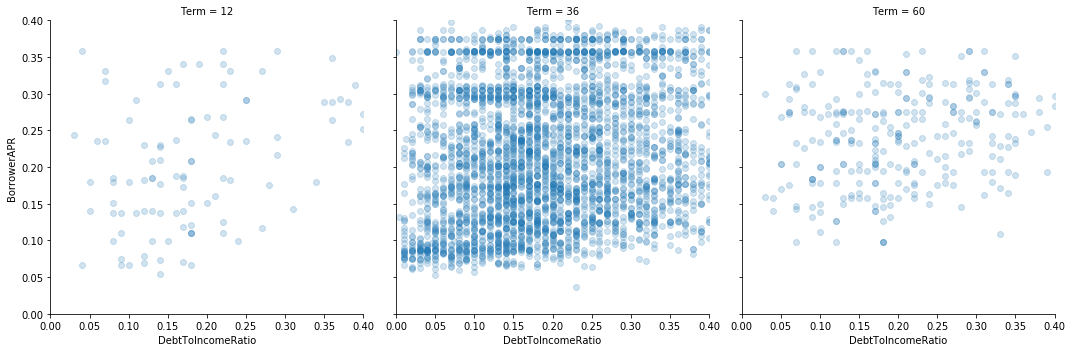

In [199]:
# Plot Borrower and Debt to income ratio for each Term

# Plot a sample of the data to make the plot easier to read
samples = np.random.choice(loans.shape[0], 10000, replace = False)
loans_samp = loans.loc[samples,:]

g = sb.FacetGrid(data = loans_samp, col = 'Term', size = 5, col_wrap = 3).set(xlim=(0,0.4), ylim=(0, 0.4))
g.map(plt.scatter, 'DebtToIncomeRatio', 'BorrowerAPR', alpha = 1/5);

Separating BorrowerAPR versus Debt-to-income ratio graphs by Term does not reveal any clear differences between the terms. The lowest BorrowerAPr values for 60-month loans tend to be around 0.1 while for 12 and 3 month terms these go as low as 0.05, so long-term loans appear to slightly increase the overall BorrowerAPR.

To analyse the relationship between Monthly Loan Payment and the other financial variables I first need to remove the outliers. I will remove Monthly Loan Payments below \\$500.

In [143]:
# Remove Monthly Loan Payments above $500
sub_500 = loans['MonthlyLoanPayment'] < 500
financials =  loans.loc[sub_500,:]

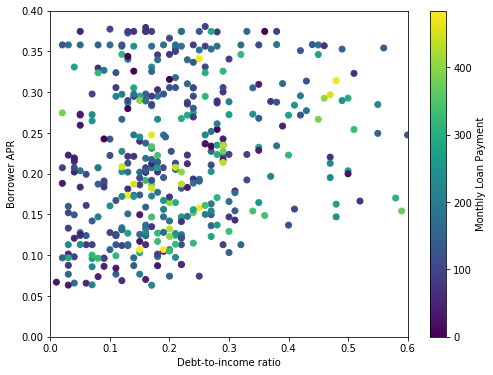

In [201]:
# Plot Borrower APR, Debt to income ratio and Monthly Loan Payment

# Plot a sample of the data to make the plot easier to read
samples = np.random.choice(financials.shape[0], 1000, replace = False)
financials_samp = financials.loc[samples,:]

plt.figure(figsize = [8,6])
plt.scatter(data = financials_samp, x = 'DebtToIncomeRatio', y = 'BorrowerAPR', c = 'MonthlyLoanPayment')
plt.colorbar(label = 'Monthly Loan Payment')
plt.xlim([0, 0.6])
plt.ylim([0, 0.4])
plt.xlabel('Debt-to-income ratio')
plt.ylabel('Borrower APR');

For Monthly Loan Payments, lower monthly payments appear to be associated with lower debt-to-income ratios. The effect of BorrowerAPR seems lower as there are a number of low-value monthly loan payments even at higher BorrowerAPR values.

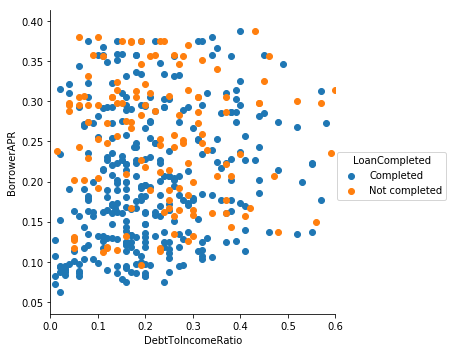

In [197]:
# Plot Loan completion, Debt-to-income ratio and Borrower APR

# Plot a sample of the data to make the plot easier to read
samples = np.random.choice(loans.shape[0], 1000, replace = False)
loans_samp = loans.loc[samples,:]

g = sb.FacetGrid(data = loans_samp, hue = 'LoanCompleted', size = 5)
g.map(plt.scatter, 'DebtToIncomeRatio', 'BorrowerAPR')
g.set(xlim = (0,0.6))
g.add_legend();

Loans with the lowest BorrowerAPR values appear more likely to be paid off. The relationship between BorrowerAPR and Debt-to-income ratios with regards to Loan Completion is less clear. At the low end for both BorrowerAPR and Debt-to-income ratio most loans are paid off. The area of the graph below 0.17 BorrowerAPR and 0.25 Debt-to-income ratio largely shows loans being paid off. As either the BorrowerAPR or Deb-to-income ratio increases above these levels, however, the loan completion rate decreases.

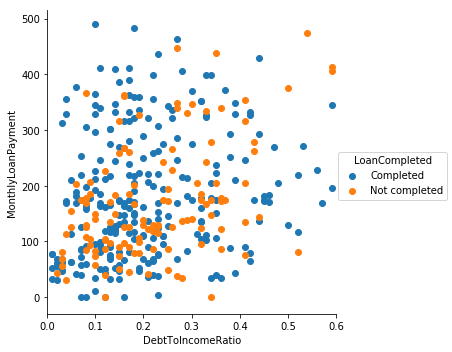

In [215]:
# Plot Loan completion, Debt-to-income ratio and Monthly Loan Payment

# Plot a sample of the data to make the plot easier to read
samples = np.random.choice(financials.shape[0], 1000, replace = False)
financials_samp = financials.loc[samples,:]

g = sb.FacetGrid(data = financials_samp, hue = 'LoanCompleted', size = 5)
g.map(plt.scatter, 'DebtToIncomeRatio', 'MonthlyLoanPayment')
g.set(xlim = (0,0.6))
g.add_legend();

There is no clear relationship for Monthly Loan Payments and Debt-to-income ratios with regards to Loan completion. Loans tend to have higher completion at lower Debt-to-income ratios but there are still plenty at low levels that are not completed.

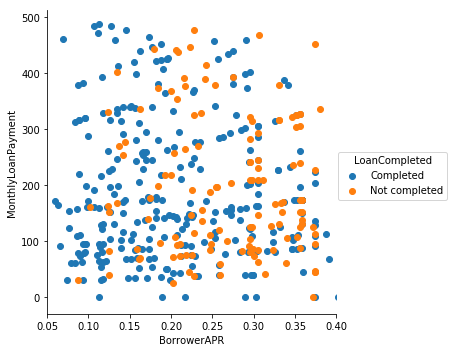

In [219]:
# Plot Loan completion, BorrowerAPR and Monthly Loan Payment

# Plot a sample of the data to make the plot easier to read
samples = np.random.choice(financials.shape[0], 1000, replace = False)
financials_samp = financials.loc[samples,:]

g = sb.FacetGrid(data = financials_samp, hue = 'LoanCompleted', size = 5)
g.map(plt.scatter, 'BorrowerAPR', 'MonthlyLoanPayment')
g.set(xlim = (0.05, 0.4))
g.add_legend();

The trend here is that as BorrowerAPR increases the likelihood of the loan being completed decreases. Higher monthly loan payments appear to compound this as there are a lot of non-complted loans at the top right of the graph and far fewer at the bottom left of the graph.

In [186]:
# Plot Loan completion, Debt-to-income ratio and StatedMonthlyIncome

In [95]:
# Plot Loan Term, Loan Completion and Monthly Loan Payment

In [96]:
# Plot Debt-to-income, Monthly Loan Payment, Credit Score

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!